# Worksheet 6 - Neural Networks 1
Nils Voß, Julia Lamprecht

(a) Data Loading and Preprocessing:
We'll start by loading the data and applying any necessary preprocessing steps. We'll then plot examples of both classes from the training and test sets.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import math
import itertools
import numpy as np

In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2.15.0


We begin by loading the training and test datasets from CSV files using pandas. This data includes observations of stars, with a label indicating whether a star has an exoplanet (2) or not (1). To make the labels compatible with the neural network's output (which typically uses 0 and 1 for binary classification), we subtract 1 from the label values, converting them to 0 (no exoplanet) and 1 (exoplanet). Additionally, we normalize the features to ensure the data is scaled appropriately for training the neural network. Finally, we split the training data into training and validation sets to monitor the model's performance during training.

Training Data:
   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.

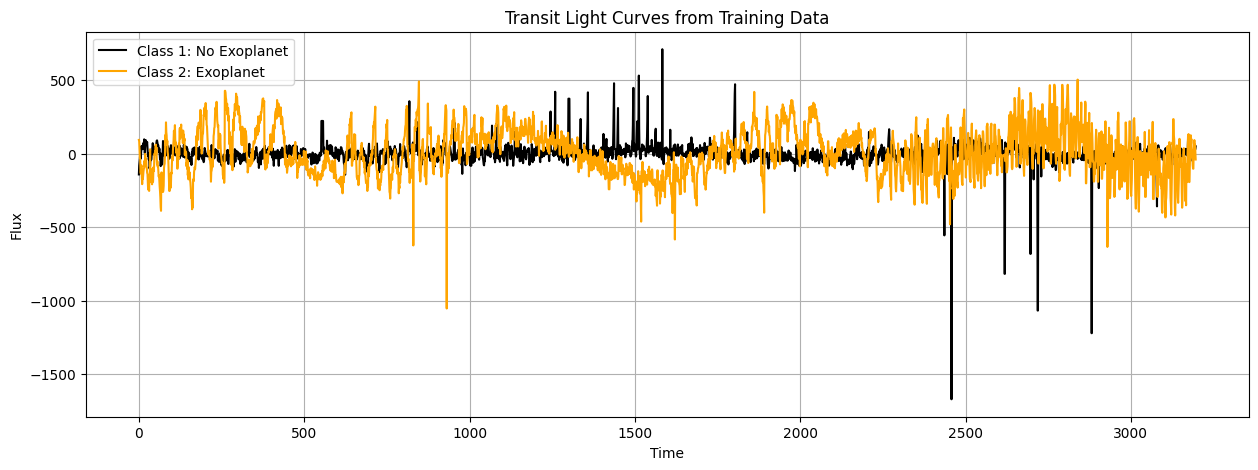

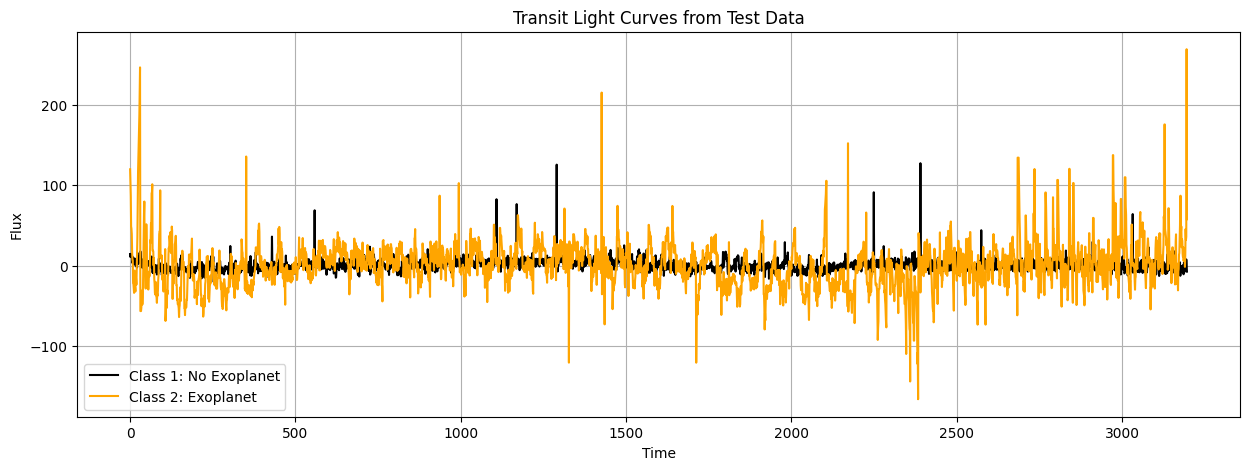

Rows before removing outliers: 5087 (train) and  570 (test)
Rows after removing outliers: 5047 (train) and  560 (test)


In [3]:
# Load the data
train_data = pd.read_csv('/content/sample_data/exoTrain.csv')
test_data = pd.read_csv('/content/sample_data/exoTest.csv')

# Display the first few rows of the training data
print("Training Data:")
print(train_data.head())

# Display the first few rows of the test data
print("\nTest Data:")
print(test_data.head())

# Plot examples of both classes from the training data
plt.figure(figsize=(15, 5))
class_1_example = train_data[train_data['LABEL'] == 1].iloc[0, 1:].values
class_2_example = train_data[train_data['LABEL'] == 2].iloc[0, 1:].values

plt.plot(class_1_example, label='Class 1: No Exoplanet', color='black')
plt.plot(class_2_example, label='Class 2: Exoplanet', color='orange')
plt.title('Transit Light Curves from Training Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid()
plt.legend()
plt.show()

# Plot examples of both classes from the test data
plt.figure(figsize=(15, 5))
class_1_example_test = test_data[test_data['LABEL'] == 1].iloc[0, 1:].values
class_2_example_test = test_data[test_data['LABEL'] == 2].iloc[0, 1:].values

plt.plot(class_1_example_test, label='Class 1: No Exoplanet', color='black')
plt.plot(class_2_example_test, label='Class 2: Exoplanet', color='orange')
plt.title('Transit Light Curves from Test Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid()
plt.legend()
plt.show()

# Preprocessing
# Convert labels to 0 and 1
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].apply(lambda x: 0 if x == 1 else 1).values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].apply(lambda x: 0 if x == 1 else 1).values

print('Rows before removing outliers:', X_train.shape[0], '(train) and ', X_test.shape[0], '(test)')

z_threshold = 3
zscore_train = np.abs((X_train - X_train.mean()) / X_train.std())
zscore_test = np.abs((X_test - X_test.mean()) / X_test.std())

X_train = X_train[(zscore_train < z_threshold).all(axis=1)]
y_train = y_train[(zscore_train < z_threshold).all(axis=1)]
X_test = X_test[(zscore_test < z_threshold).all(axis=1)]
y_test = y_test[(zscore_test < z_threshold).all(axis=1)]

print('Rows after removing outliers:', X_train.shape[0], '(train) and ', X_test.shape[0], '(test)')

# Standardize the data (the features = X)
scaler = StandardScaler() # Select scaling method
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Split training data into train and validation sets: One set for training and one for validating the model during the training
# Choose random_state = 42 to ensure reproducibility
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


(b) Model Creation:
We'll create a feedforward neural network model.


We define a neural network model using Keras.

We initialize a sequential model using the Sequential class. This should be appropriate for a stack of layers where each layer has one input and one output tensor.

We use three dense layers using the Dense class. Each dense layers represents a linear transformation followed by an activation function.

1. Layer: 128 Neurons with a ReLu activation function
2. Layer: 64 Neurons with a ReLu activation function
3. Layer: One single neuron with a sigmoid acitvation function. Common for binary classification tasks, where the output represents the probability of belonging to one class.

The Dropout Layers prevent overfitting. This is a regularization technique that randomly sets a fraction of input units to zero during training. We chose a dropout rate of 0.3 that is added after the 1. and 2. dense layers. Meaning during the training, 30% of the input units will be randomly set to 0 at every update.

The model is compiled with the Adam optimizer and binary cross-entropy loss function, which are commonly used for binary classification tasks.

In [4]:


# Create the model
model = Sequential([
    Dense(128, activation='relu', name='hidden_layer', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, name='output_layer', activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])



(c) Train the model

We train the model using the training data.

During each epoch, the model processes the entire training data in batches of 32 samples. For each batch, the model makes predications, calculates the loss between the predications and the true label and updates the weights to minimize the loss (using the Adam optimizer).

After every epoch, the performance on the validation data gets evaluated, already here in the training phase. Validation metrics (loss and accuracy) are computed and stored in the history object.



In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_val, y_val))


Epoch 1/50
127/127 [==============================] - 4s 17ms/step - loss: 0.1181 - accuracy: 0.9903 - val_loss: 0.0574 - val_accuracy: 0.9911
Epoch 2/50
127/127 [==============================] - 2s 13ms/step - loss: 0.0515 - accuracy: 0.9923 - val_loss: 0.0564 - val_accuracy: 0.9921
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0796 - accuracy: 0.9931 - val_loss: 0.0595 - val_accuracy: 0.9911
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0514 - accuracy: 0.9933 - val_loss: 0.0786 - val_accuracy: 0.9911
Epoch 5/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0555 - accuracy: 0.9928 - val_loss: 0.0526 - val_accuracy: 0.9921
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0442 - accuracy: 0.9948 - val_loss: 0.0614 - val_accuracy: 0.9901
Epoch 7/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0510 - accuracy: 0.9946 - val_loss: 0.0591 - val_accuracy: 0.9901
Epoc

(d) Evaluate the model on a validation and test data set

Although performance on validation data has been evaluated before, we explicitly call the mode.evaluate function to confirm the final validation metrics once the training is complete.

In [6]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 5ms/step - loss: 0.2349 - accuracy: 0.9891
Validation Loss: 0.23489825427532196
Validation Accuracy: 0.9891089200973511
18/18 [==============================] - 0s 6ms/step - loss: 0.5091 - accuracy: 0.9911
Test Loss: 0.5091063380241394
Test Accuracy: 0.9910714030265808


(e) Can your network classify the stars correctly? Compare the predicted class with
the observed class.

We generate predictions for the test data and compare them with the actual labels to assess the model's classification performance.

The model.predict function uses the trained model to make predictions on the test data. The output are the predicted probabilities, with each value prepresenting the probability that the corresponding test sample belongs a the class of a detected Exoplanet. We compare the predicted probabilities to a threshold of 0.5. (Greater than that -> 1, meaning Exoplanet detected. Smaller than that -> 0, no Exoplanet) Here all

In [7]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compare predicted class with observed class
comparison = pd.DataFrame({'Observed': y_test, 'Predicted': y_pred.flatten()})
print(comparison.head(15))

# Count the occurrences of each class in the 'Predicted' column
predicted_class_counts = comparison['Predicted'].value_counts()
observed_class_counts = comparison['Observed'].value_counts()

# Print the counts for predicted classes
print("Number of samples predicted with an exoplanet:", predicted_class_counts.get(1, 0))
print("Number of samples predicted without an exoplanet:", predicted_class_counts.get(0, 0))

# Print the counts for observed classes
print("Number of samples observed with an exoplanet:", observed_class_counts.get(1, 0))
print("Number of samples observed without an exoplanet:", observed_class_counts.get(0, 0))


18/18 [==============================] - 0s 4ms/step
    Observed  Predicted
0          1          0
1          1          0
2          1          0
3          1          0
4          1          0
5          0          0
6          0          0
7          0          0
8          0          0
9          0          0
10         0          0
11         0          0
12         0          0
13         0          0
14         0          0
Number of samples predicted with an exoplanet: 0
Number of samples predicted without an exoplanet: 560
Number of samples observed with an exoplanet: 5
Number of samples observed without an exoplanet: 555


A confusion matrix is a table used to evaluate the performance of a classification model by comparing the predicted labels with the true labels. It provides a comprehensive view of how well the model is distinguishing between the different classes. The matrix is printed to show the counts of true positives, true negatives, false positives, and false negatives.

The model correctly predicted 555x "No Exoplanet". (True Negative) The model incorrectly predicted 0x "Exoplanet" when it was actually "No Exoplanet". (False Positive) The model incorrectly predicted 5x "No Exoplanet" when it was actually "Exoplanet". (False Negative) The model correctly predicted 0x "Exoplanet". (True Positive)

The classification report shows information about the model's performance, including precision, recall, F1-score and support for each class.

Precision is the ratio of correctly predicted positive observations to the total predicted pisitives.
The Recall is the sensitivity: The ratio of correctly predicted positive observations to tall actual positives.

F1-Score: The harmonic mean of precision and recall.
Support: The number of actual occurrences of the class in the dataset.

In [8]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=['No Exoplanet', 'Exoplanet'])
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[555   0]
 [  5   0]]
Classification Report:
              precision    recall  f1-score   support

No Exoplanet       0.99      1.00      1.00       555
   Exoplanet       0.00      0.00      0.00         5

    accuracy                           0.99       560
   macro avg       0.50      0.50      0.50       560
weighted avg       0.98      0.99      0.99       560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In the classification report, the precision for identifying "No Exoplanet" samples is exceptionally high at 99%, indicating that almost all samples classified as "No Exoplanet" are indeed "No Exoplanet." However, the precision for identifying "Exoplanet" samples is 0%, meaning none of the samples classified as "Exoplanet" are actually "Exoplanet." Similarly, the recall for "No Exoplanet" is 100%, indicating that all actual "No Exoplanet" samples are correctly identified, while the recall for "Exoplanet" is 0%, meaning none of the actual "Exoplanet" samples are identified by the model. Consequently, the F1-score, which combines precision and recall, is perfect for "No Exoplanet" but 0 for "Exoplanet," indicating a complete failure in identifying "Exoplanet" samples. The overall accuracy of the model is high at 99%, but this is heavily influenced by the abundance of "No Exoplanet" samples in the dataset. The macro average precision, recall, and F1-score are all 0.50, while the weighted average metrics are significantly higher due to the dominance of the "No Exoplanet" class.


To address this, techniques such as resampling (oversampling the minority class or undersampling the majority class), using different metrics for model evaluation, or applying class weights during model training could be considered to improve the model's performance on the minority class.

(f) Tune the different hyperparameters and note down how the model predictions
improve/worsen with the changes. Visualsize the changes (e.g., plot the test loss and
accuracy as a function of the hyperparameters).

We experiment with different hyperparameters, such as learning rates, batch sizes, neurons, and dropout rates, to find the best configuration for our model. By plotting the training loss and accuracy, we can visualize how changes in hyperparameters affect the model's performance. This helps us optimize the model for better accuracy and generalization.

In [ ]:


# Define the model creation function
def create_model(learning_rate=0.001, num_neurons=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define hyperparameter values
learning_rates = [0.01, 0.1]
batch_sizes = [32, 64]
num_neurons = [64, 128]
dropout_rates = [0.3, 0.5]

# Create combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, num_neurons, dropout_rates))

# Store training histories
histories = []

# Train models for each combination of hyperparameters
for lr, batch_size, neurons, dropout_rate in hyperparameter_combinations:
    print(f"Training model with LR={lr}, Batch Size={batch_size}, Neurons={neurons}, Dropout={dropout_rate}")

    model = create_model(lr, neurons, dropout_rate)

    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    histories.append((lr, batch_size, neurons, dropout_rate, history))
    print("Training completed.\n")



Training model with LR=0.01, Batch Size=32, Neurons=64, Dropout=0.3
Training completed.

Training model with LR=0.01, Batch Size=32, Neurons=64, Dropout=0.5
Training completed.

Training model with LR=0.01, Batch Size=32, Neurons=128, Dropout=0.3
Training completed.

Training model with LR=0.01, Batch Size=32, Neurons=128, Dropout=0.5
Training completed.

Training model with LR=0.01, Batch Size=64, Neurons=64, Dropout=0.3


In [ ]:
# Calculate the number of rows and columns needed for plotting
num_plots = len(histories)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

plt.figure(figsize=(15, num_rows * 10))

# Plot training loss and accuracy separately
for i, (lr, batch_size, neurons, dropout_rate, history) in enumerate(histories):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'LR={lr}, Batch Size={batch_size}, Neurons={neurons}, Dropout={dropout_rate} - Loss')
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, num_rows * 10))

for i, (lr, batch_size, neurons, dropout_rate, history) in enumerate(histories):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'LR={lr}, Batch Size={batch_size}, Neurons={neurons}, Dropout={dropout_rate} - Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
